In [1]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = get_dax_data()

In [3]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [4]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-11-08,15229.599609,0.506613,0.616686,0.265294,0.566290,2.031917
2023-11-09,15352.540039,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10,15234.389648,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13,15345.000000,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14,15614.429688,1.740578,2.464012,1.691453,2.495459,3.002072


In [5]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        pred = model['function'](df_before)
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            
            
            print(f'Obs: :{observation}:')
            print(type(observation))
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [6]:
from DAX.Models.baseline_100 import baseline_100
from DAX.Models.baseline_300 import baseline_300

models = [
    {
        'name': 'baseline',
        'function': baseline
     },
    {
        'name': 'baseline_300',
        'function': baseline_300
     },
    {
        'name': 'baseline_100',
        'function': baseline_100
     },
]


In [7]:
evaluate_models(models, df, 100, weeks=True)

*********** Start the evaluation of Model baseline ***********
Iteration 1 of 100
Obs: :0.7234338895523607:
<class 'numpy.float64'>
Obs: :2.464011751691153:
<class 'numpy.float64'>
Obs: :3.3168813907746397:
<class 'numpy.float64'>
Obs: :3.5606785467660274:
<class 'numpy.float64'>
Obs: :4.396807584412343:
<class 'numpy.float64'>
Iteration 2 of 100
Obs: :-0.3513928587622672:
<class 'numpy.float64'>
Obs: :-0.2413189801515614:
<class 'numpy.float64'>
Obs: :0.26529361602047885:
<class 'numpy.float64'>
Obs: :1.0692994401072298:
<class 'numpy.float64'>
Obs: :0.2967408376003178:
<class 'numpy.float64'>
Iteration 3 of 100
Obs: :0.19813591132358255:
<class 'numpy.float64'>
Obs: :0.8334900062910933:
<class 'numpy.float64'>
Obs: :1.5931033387357019:
<class 'numpy.float64'>
Obs: :3.0587299798174428:
<class 'numpy.float64'>
Obs: :3.3597265935780385:
<class 'numpy.float64'>
Iteration 4 of 100
Obs: :0.015203119044215896:
<class 'numpy.float64'>
Obs: :0.5490247445354868:
<class 'numpy.float64'>
Obs: :0

In [8]:
df.tail(10)

,Close,ret1,ret2,ret3,ret4,ret5
Date,,,,,,
2023-11-06 00:00:00+01:00,15135.969727,-0.351393,-0.050396,1.415230,2.174844,2.810198
2023-11-07 00:00:00+01:00,15152.639648,0.110074,-0.241319,0.059678,1.525304,2.284918
2023-11-08 00:00:00+01:00,15229.599609,0.506613,0.616686,0.265294,0.566290,2.031917
2023-11-09 00:00:00+01:00,15352.540039,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10 00:00:00+01:00,15234.389648,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13 00:00:00+01:00,15345.000000,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14 00:00:00+01:00,15614.429688,1.740578,2.464012,1.691453,2.495459,3.002072
2023-11-15 00:00:00+01:00,15748.169922,0.852870,2.593448,3.316881,2.544323,3.348329
2023-11-16 00:00:00+01:00,15786.610352,0.243797,1.096667,2.837245,3.560679,2.788120


In [9]:
with open('./Model evaluations/baseline.pkl', 'wb') as f:
    pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [10]:
models[0]['evaluation']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,observation,score
forecast_date,,,,,,,,,
2021-12-17,DAX,1 day,-2.710994,-0.485397,0.075470,0.662321,2.438222,-0.671907,1.951719
2021-12-20,DAX,2 day,-3.936562,-0.748017,0.162165,0.914373,3.132972,-2.569966,7.560701
2021-12-21,DAX,5 day,-4.759447,-0.849379,0.165364,1.226143,3.890326,-1.215823,3.584326
2021-12-22,DAX,6 day,-5.246158,-0.964597,0.242305,1.414134,4.574074,-0.274934,2.197615
2021-12-23,DAX,7 day,-5.753083,-1.093500,0.385871,1.493921,5.192237,0.763934,2.219039
...,...,...,...,...,...,...,...,...,...
2023-11-13,DAX,1 day,-3.321265,-0.551383,0.057215,0.715600,2.719772,0.723434,1.61743
2023-11-14,DAX,2 day,-4.087895,-0.823250,0.072355,0.978977,3.570492,2.464012,6.645759
2023-11-15,DAX,5 day,-5.259161,-0.917655,0.147247,1.209531,4.628697,3.316881,8.942321


In [11]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for m in models:
    scores_m = m['evaluation'].loc[:,('horizon','score')]
    names.append(f'horizon_{m["name"]}')
    names.append(m["name"])
    scores.append(scores_m)

score_df = pd.concat(scores, axis=1)
score_df.columns = names

In [12]:
score_df

,horizon_baseline,baseline,horizon_baseline_300,baseline_300,horizon_baseline_100,baseline_100
forecast_date,,,,,,
2021-12-17,1 day,1.951719,1 day,2.099213,1 day,1.896034
2021-12-20,2 day,7.560701,2 day,7.692584,2 day,7.616965
2021-12-21,5 day,3.584326,5 day,3.7749,5 day,3.464535
2021-12-22,6 day,2.197615,6 day,1.810879,6 day,1.802333
2021-12-23,7 day,2.219039,7 day,1.7651,7 day,1.871418
...,...,...,...,...,...,...
2023-11-13,1 day,1.61743,1 day,1.624882,1 day,1.874926
2023-11-14,2 day,6.645759,2 day,6.616809,2 day,7.718073
2023-11-15,5 day,8.942321,5 day,8.785741,5 day,11.058031


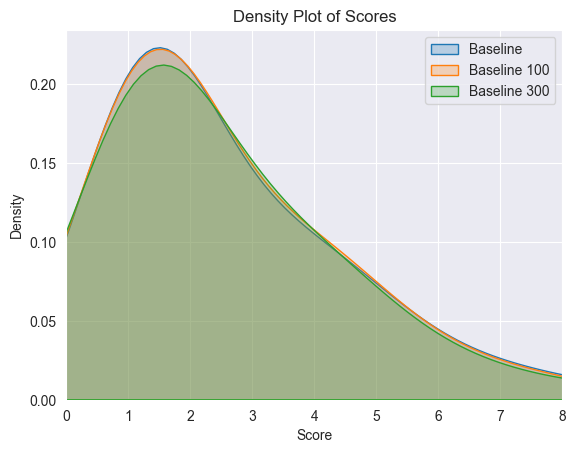

In [23]:
horizon = '1 day'
filtered_df = score_df[score_df['horizon_baseline'] == horizon]
sns.kdeplot(data=filtered_df['baseline'], fill=True, label='Baseline')
sns.kdeplot(data=filtered_df['baseline_100'], fill=True, label='Baseline 100')
sns.kdeplot(data=filtered_df['baseline_300'], fill=True, label='Baseline 300')


# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Density Plot of Scores')
plt.legend()

plt.xlim(0,8)
# Display the plot
plt.show()

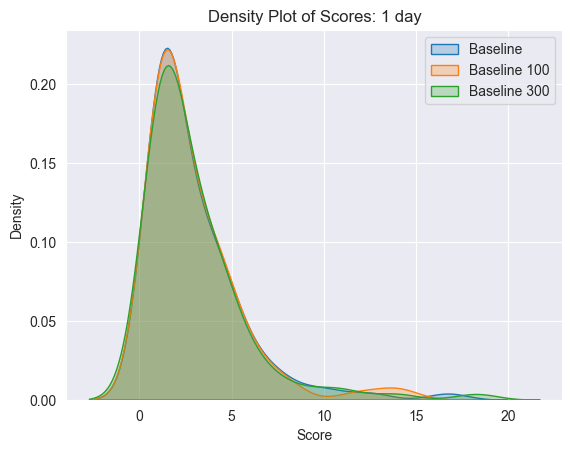

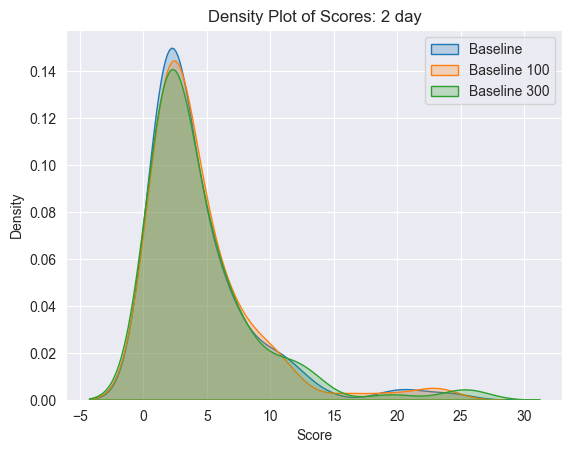

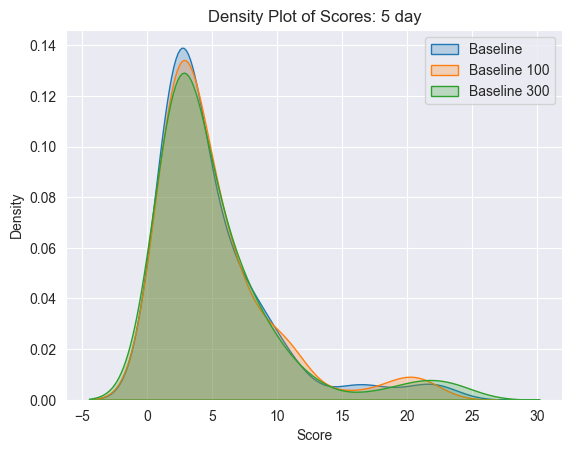

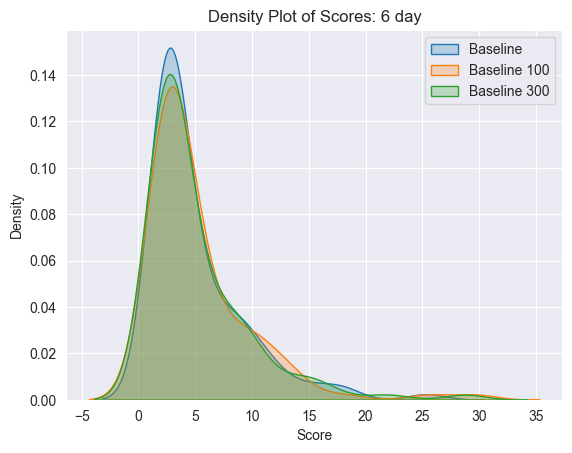

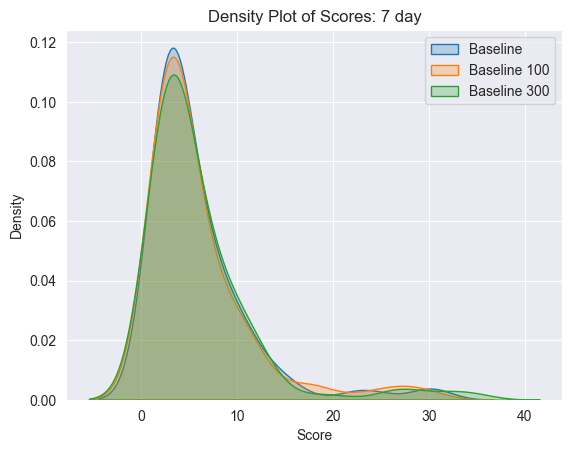

In [25]:
for horizon in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    filtered_df = score_df[score_df['horizon_baseline'] == horizon]
    sns.kdeplot(data=filtered_df['baseline'], fill=True, label='Baseline')
    sns.kdeplot(data=filtered_df['baseline_100'], fill=True, label='Baseline 100')
    sns.kdeplot(data=filtered_df['baseline_300'], fill=True, label='Baseline 300')
    
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {horizon}')
    plt.legend()
    
    # plt.xlim(0,8)
    # Display the plot
    plt.show()